# 信号处理仿真与应用 - 数字和模拟滤波器取 - 数字滤波器分析

## impzlength

#### 滤波器脉冲响应长度

**给出python函数**

In [4]:
import numpy as np
from scipy import signal
from scipy.signal import ellip, zpk2sos, firwin, butter

def impzlength(b, *args):
    if isinstance(b, np.ndarray) and b.ndim == 2 and b.shape[1] == 6:
        # SOS 矩阵情况
       # if not np.isclose(np.linalg.norm(b), 0.0):
       #     raise ValueError("参数 'b' 必须是非空的 SOS 矩阵.")

        if len(args) > 0:
            tol = args[0]
        else:
            tol = 0.00005
        return lclsosimpzlength(b, tol)
    else:
        # 传递函数情况
        isTF = True
        if len(args) == 0:
            a = np.array([1.0])  # 传递函数的默认 'a'
        else:
            a = args[0]

        if len(args) < 2:
            tol = 0.00005
        else:
            tol = float(args[1])

        return calculate_impz_length(b, a, tol, isTF)

def calculate_impz_length(b, a, tol, isTF):
    if isTF:
        # 判断滤波器是否为 FIR（所有 'a' 的元素接近于零）
        if np.allclose(a, 0.0, atol=1e-15):
            return len(b)  # FIR 滤波器的长度
        else:
            # 找到向量 b 中第一个非零元素的索引，作为延迟 delay
            delay = find_first_nonzero_index(b)

            # 根据稳定性和延迟计算长度
            p = np.roots(a)
            if np.any(np.abs(p) > 1.0001):
                N = unstable_length(p)
            else:
                N = stableNmarginal_length(p, tol, delay)

            return int(np.ceil(N))-1  # 确保 N 是整数并向上取整
    else:
        return lclsosimpzlength(b, tol)

def find_first_nonzero_index(arr):
    # 找到数组 arr 中第一个非零元素的索引
    indices = np.nonzero(arr)[0]  # 找到所有非零元素的索引
    if len(indices) == 0:
        return 0  # 如果数组中没有非零元素，返回索引 0（默认延迟为 0）
    else:
        return indices[0]  # 返回第一个非零元素的索引

def unstable_length(p):
    ind = np.abs(p) > 1
    return int(6 / np.log10(np.max(np.abs(p[ind]))))

def stableNmarginal_length(p, tol, delay):
    n = len(p)
    nOscillation = 0
    indOscillation = []
    nDamped = 0
    indDamped = []

    # 遍历极点 p
    for i in range(n):
        # 如果极点接近于1，则取其相反数
        if np.abs(p[i] - 1) < 1e-5:
            p[i] = -p[i]
        
        # 判断极点是振荡还是非振荡
        if np.abs(np.abs(p[i]) - 1) < 1e-5:
            nOscillation += 1
            indOscillation.append(i)
        else:
            nDamped += 1
            indDamped.append(i)

    if nOscillation == n:  # 全部为振荡极点
        periods = 5 * np.max(2 * np.pi / np.abs(np.angle(p)))
        N = periods
    elif nOscillation == 0:  # 全部为非振荡极点
        maxp = np.max(np.abs(p))
        maxind = np.argmax(np.abs(p))
        multiplicity = mltplcty(p, maxind, tol)
        N = multiplicity * np.log10(tol) / np.log10(maxp) + delay
    else:  # 部分振荡部分非振荡
        pOscillation = p[indOscillation]
        pDamped = p[indDamped]
        periods = 5 * np.max(2 * np.pi / np.abs(np.angle(pOscillation)))
        maxp = np.max(np.abs(pDamped))
        maxind = np.argmax(np.abs(pDamped))
        multiplicity = mltplcty(pDamped, maxind, tol)
        N = max(periods, multiplicity * np.log10(tol) / np.log10(maxp)) + delay

    return N

def mltplcty(p, ind, tol=0.001):
    if np.any(p == 0):
        thresh = np.float(tol)
    else:
        thresh = tol * np.abs(p[ind])
    
    m = 0
    for i in range(len(p)):
        if np.abs(p[i] - p[ind]) < thresh:
            m += 1
    
    return m

def lclsosimpzlength(sos, tol):
    firlen = 1
    iirlen = 1
    num_sections = sos.shape[0]
    for k in range(num_sections):
        b = sos[k, 0:3]
        a = sos[k, 3:6]
        if np.allclose(a, 0.0, atol=1e-15):
            return len(b)  # FIR 滤波器的长度
        else:
            iirlen = max(iirlen, impzlength(b, a, tol))
    return max(firlen, iirlen)

**采用文件调用**

示例1

创建一个极点为 0.9 的低通全极点 IIR 滤波器。计算有效脉冲响应长度。获取脉冲响应。绘制结果图。

Impulse response length N: 93


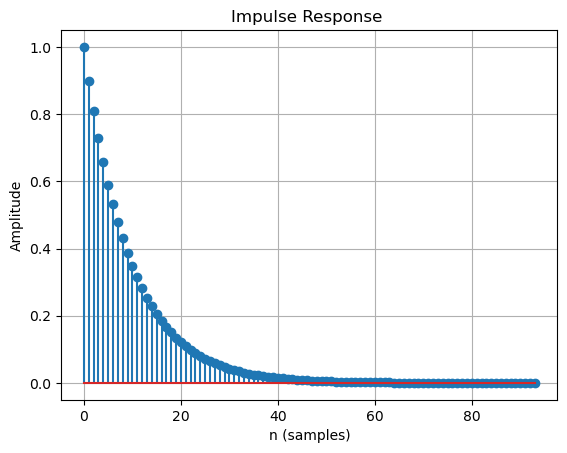

In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import ellip, zpk2sos, firwin, butter
from impzlength import impzlength
from impz import impz

# 示例1
b = np.array([1.0])
a = np.array([1.0, -0.9])
N = impzlength(b,a)
print("Impulse response length N:", N)
num_samples = 93
h, t = impz(b, a, num_samples)
# 绘制脉冲响应图
plt.stem(t,h)
plt.title('Impulse Response ')
plt.xlabel('n (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

**采用文件调用**

示例2

设计了一个截止频率为0.4πrad/sample的四阶低通椭圆滤波器。指定1dB的通带纹波和60 dB的阻带衰减。将滤波器设计为极点零增益形式，并使用zp2sos获得二阶截面矩阵。根据二阶截面矩阵确定有效脉冲响应序列长度。

In [6]:
import numpy as np
from scipy import signal
from scipy.signal import ellip, zpk2sos, firwin, butter
from impzlength import impzlength

# 示例2
# 设计椭圆低通滤波器
N = 4  # 滤波器阶数
rp = 1  # 通带最大允许波纹（dB）
rs = 60  # 阻带最小衰减（dB）
cutoff = 0.4  # 截止频率（归一化频率，范围为0到1）
# 设计椭圆滤波器
b, a = ellip(N, rp, rs, cutoff, output='ba')
# 获取零极点增益（ZPK）表示
z, p, k = ellip(N, rp, rs, cutoff, output='zpk')
# 将零极点表示转换为二阶段（Second-Order Sections，SOS）表示
sos = zpk2sos(z, p, k)
N = impzlength(sos)
print("Impulse response length N:", N)
plt.show()

Impulse response length N: 80
